Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/ML/Cancer_data/Train")
data_dir_test = pathlib.Path("gdrive/My Drive/ML/Cancer_data/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train, 
            seed=123, 
            validation_split=0.2, 
            subset='training', 
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 5239 files belonging to 9 classes.
Using 4192 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train, 
            seed=123, 
            validation_split=0.2,  
            subset='validation',
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 5239 files belonging to 9 classes.
Using 1047 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

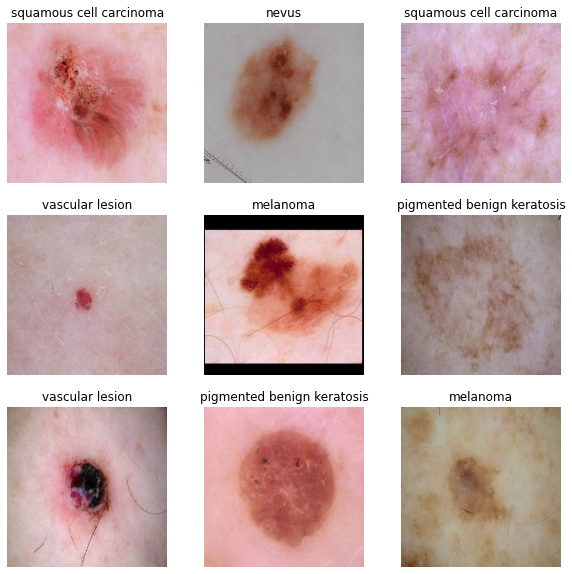

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for images , labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
# number of classes to detect
classes = 9  

# Building a model witout the dropouts
model = Sequential([
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_height, 3)),
          layers.Conv2D(32, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(pool_size=(2,2)),
          layers.Conv2D(64, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(pool_size=(2,2)),
          layers.Conv2D(128, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(pool_size=(2,2)),
          layers.Flatten(),
          layers.Dense(256, activation="relu"),
          layers.Dense(classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
131/131 [==============================] - 25s 63ms/step - loss: 2.0420 - accuracy: 0.2529 - val_loss: 1.5421 - val_accuracy: 0.4136
Epoch 2/20
131/131 [==============================] - 5s 40ms/step - loss: 1.4211 - accuracy: 0.4776 - val_loss: 1.2546 - val_accuracy: 0.5043
Epoch 3/20
131/131 [==============================] - 5s 41ms/step - loss: 1.1965 - accuracy: 0.5587 - val_loss: 1.0874 - val_accuracy: 0.5836
Epoch 4/20
131/131 [==============================] - 5s 40ms/step - loss: 1.0578 - accuracy: 0.6126 - val_loss: 0.9954 - val_accuracy: 0.6380
Epoch 5/20
131/131 [==============================] - 5s 41ms/step - loss: 0.9111 - accuracy: 0.6751 - val_loss: 0.8933 - val_accuracy: 0.6590
Epoch 6/20
131/131 [==============================] - 5s 40ms/step - loss: 0.7711 - accuracy: 0.7252 - val_loss: 0.8590 - val_accuracy: 0.6982
Epoch 7/20
131/131 [==============================] - 5s 41ms/step - loss: 0.6637 - accuracy: 0.7615 - val_loss: 0.8865 - val_accuracy: 0.701

### Visualizing training results

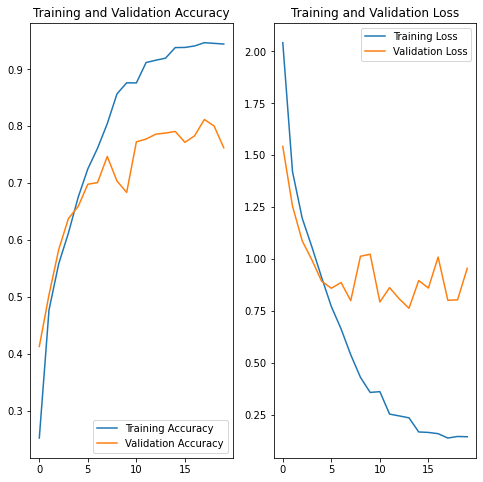

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. The above result shows that the model is overfitting due to high accuracy and difference between the acurracy and validation accuracy. It could be due to that the model is not generalizing properly. 
2. In this situation, Data Augmentation could help solve overfitting by increasing the diversity of dataset by applying random but realistic transformations such as image rotation, shearing, hortizontal & vertical flips, zooming, de-centering etc.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                 layers.experimental.preprocessing.RandomRotation(0.1),
                                 layers.experimental.preprocessing.RandomZoom(0.1)])

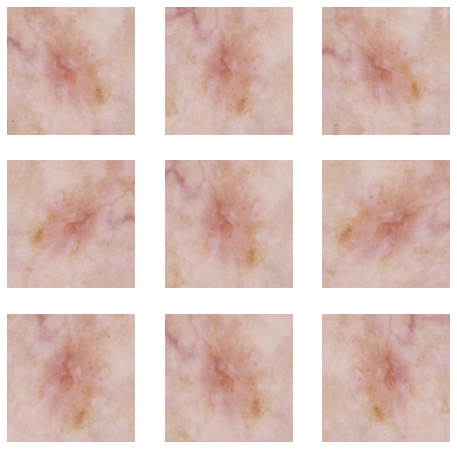

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
  for i in range(9):
    aug_images = augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(aug_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

# Building the model after augmentation and with dropouts
model = Sequential([
          augmentation,
          layers.experimental.preprocessing.Rescaling(1./255),
          layers.Conv2D(32, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(pool_size=(2,2)),
          layers.Conv2D(64, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(pool_size=(2,2)),
          layers.Conv2D(128, 3, padding="same", activation="relu"),
          layers.MaxPooling2D(pool_size=(2,2)),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(256, activation="relu"),
          layers.Dense(classes)
])


### Compiling the model

In [19]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
# Display the summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
131/131 [==============================] - 7s 45ms/step - loss: 1.6801 - accuracy: 0.3717 - val_loss: 1.4692 - val_accuracy: 0.4699
Epoch 2/20
131/131 [==============================] - 6s 44ms/step - loss: 1.3992 - accuracy: 0.4647 - val_loss: 1.2133 - val_accuracy: 0.5282
Epoch 3/20
131/131 [==============================] - 6s 43ms/step - loss: 1.2539 - accuracy: 0.5165 - val_loss: 1.1570 - val_accuracy: 0.5377
Epoch 4/20
131/131 [==============================] - 6s 43ms/step - loss: 1.1958 - accuracy: 0.5351 - val_loss: 1.1745 - val_accuracy: 0.5072
Epoch 5/20
131/131 [==============================] - 6s 44ms/step - loss: 1.1417 - accuracy: 0.5544 - val_loss: 1.1076 - val_accuracy: 0.5664
Epoch 6/20
131/131 [==============================] - 6s 44ms/step - loss: 1.1256 - accuracy: 0.5732 - val_loss: 1.0435 - val_accuracy: 0.5979
Epoch 7/20
131/131 [==============================] - 6s 43ms/step - loss: 1.0603 - accuracy: 0.5923 - val_loss: 1.0599 - val_accuracy: 0.5807

### Visualizing the results

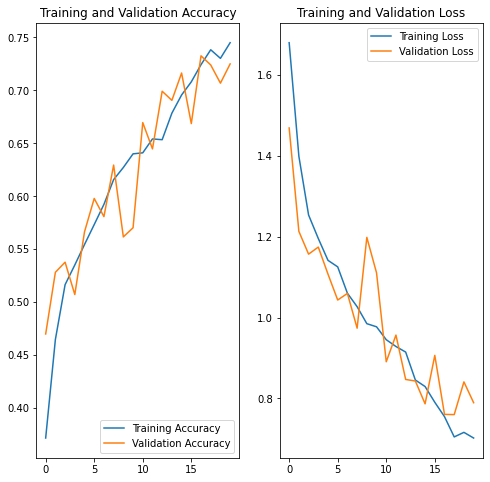

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. After applying the data augmentation, the results have been changed. It is not overfitting anymore but now it shows a sign of underfitting. 
2. The low accuracy tells us that the model is not performing well on the training data.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.

from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesion_list))

2239


In [24]:
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/ISIC_0010834.jpg', 'seborrheic keratosis'), ('gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/ISIC_0010862.jpg', 'seborrheic keratosis')]


In [25]:
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head(10)

,Path,Label
0,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
1,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
2,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
3,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
4,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
5,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
6,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
7,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
8,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis
9,gdrive/My Drive/ML/Cancer_data/Train/seborrhei...,seborrheic keratosis


In [26]:
# Displaying the number of images in each category

original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
dtype: int64

In [27]:
# Displaying the percentage of images date in each category

(original_df[['Label']].value_counts() / len(original_df)) * 100

Label                     
pigmented benign keratosis    20.634212
melanoma                      19.562305
basal cell carcinoma          16.793211
nevus                         15.944618
squamous cell carcinoma        8.083966
vascular lesion                6.208129
actinic keratosis              5.091559
dermatofibroma                 4.242966
seborrheic keratosis           3.439035
dtype: float64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

**Findings:**
1. The above findings shows the data imbalance as we can see some classes have high sample data and some very less data.
2. 'seborrheic keratosis' class contains around 3.5% of the data with 77 images which is the lowest of all.
3. Class 'pigmented benign keratosis' have around 21% of the sample data with 462 images which is highest of all.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCCE603AC90>: 100%|██████████| 500/500 [00:08<00:00, 55.82 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCCE679C6D0>: 100%|██████████| 500/500 [00:09<00:00, 51.53 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCCD25DC190>: 100%|██████████| 500/500 [00:10<00:00, 48.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCCD257AB90>: 100%|██████████| 500/500 [00:49<00:00, 10.09 Samples/s]


Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCCD25DC790>: 100%|██████████| 500/500 [00:38<00:00, 12.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCCD245CB50>: 100%|██████████| 500/500 [00:08<00:00, 56.16 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FCCD2522C90>: 100%|██████████| 500/500 [00:20<00:00, 24.05 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCCD24D4B90>: 100%|██████████| 500/500 [00:09<00:00, 54.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/ML/Cancer_data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCCD24AFC90>: 100%|██████████| 500/500 [00:08<00:00, 56.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:10]

['gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_426b1f15-7601-4d14-a412-483b67a997ac.jpg',
 'gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011187.jpg_8b362e8f-cb13-4a6a-9e18-001c986ffe1c.jpg',
 'gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011174.jpg_fdbfb069-c910-4845-9354-2468739ef02d.jpg',
 'gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_a2f563b0-f3d5-4096-b57c-b109931f9ba5.jpg',
 'gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_d267f37a-8a61-4107-bc18-cfdfa853c10c.jpg',
 'gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_045a8859-2d12-473c-84c3-2d6c1f5c8154.jpg',
 'gdrive/My Drive/ML/Cancer_data/Train/seborrheic keratosi

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [46]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [47]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [48]:
new_df.shape

(6739, 2)

In [49]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [50]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
## your code goes here

model = Sequential([
  augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(128, 3, padding="same", activation="relu"),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [55]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 21s 114ms/step - loss: 1.9238 - accuracy: 0.2799 - val_loss: 1.6063 - val_accuracy: 0.4016
Epoch 2/30
169/169 [==============================] - 20s 112ms/step - loss: 1.5240 - accuracy: 0.4108 - val_loss: 1.6304 - val_accuracy: 0.3816
Epoch 3/30
169/169 [==============================] - 19s 112ms/step - loss: 1.3943 - accuracy: 0.4653 - val_loss: 1.3872 - val_accuracy: 0.4692
Epoch 4/30
169/169 [==============================] - 20s 112ms/step - loss: 1.3233 - accuracy: 0.4961 - val_loss: 1.3273 - val_accuracy: 0.4959
Epoch 5/30
169/169 [==============================] - 19s 111ms/step - loss: 1.2738 - accuracy: 0.5104 - val_loss: 1.3092 - val_accuracy: 0.4929
Epoch 6/30
169/169 [==============================] - 20s 112ms/step - loss: 1.1922 - accuracy: 0.5451 - val_loss: 1.1693 - val_accuracy: 0.5783
Epoch 7/30
169/169 [==============================] - 20s 115ms/step - loss: 1.1786 - accuracy: 0.5453 - val_loss: 1.2519 - val_ac

#### **Todo:**  Visualize the model results

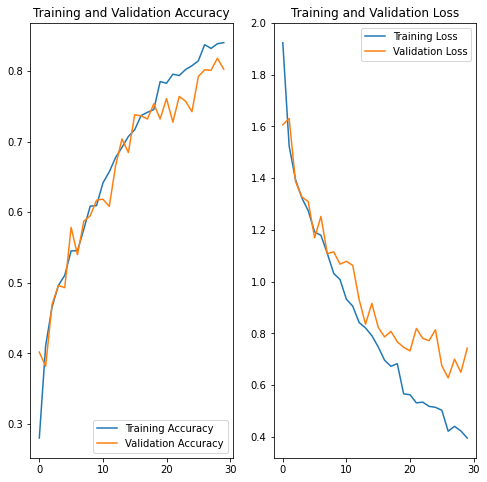

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. In the final model, class rebalanced has imporved the model performance.
2. Model training accuracy and validation accuracy both are improved. This tells us that the model is generalizing very well. 
3. There is no sign of underfitting and overfitting.
4. After 30 epochs, we are getting around 84% accuracy and around 80% of validation accuracy.
